# Actividad práctica: Predicción de series de tiempo

En esta tarea se pide entrenar y evaluar un predictor para la serie de tiempo Mackey-Glass. Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = 0.2 \frac{ y(t-\tau)}{1 + y(t-\tau)^{10}} - 0.1 y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

- Siga las instrucciones en este notebook para resolver el problema de predicción
- Conteste las preguntas que se encuentran en este enunciado
- Finalmente envíe su notebook con los resultados y respuestas a phuijse@inf.uach.cl
- No olvide cambiar el título para reflejar los integrantes de su grupo

In [164]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
import pandas as pd

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

***

Use el código que se muestra a continuación para generar la serie de tiempo Mackey Glass

- Considere una razón señal a ruido (SNR) de 2.
- Considere $\tau=17$ (comportamiento debilmente caótico)

Se generaran 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar y los siguientes 500 puntos para hacer predicción

<IPython.core.display.Javascript object>


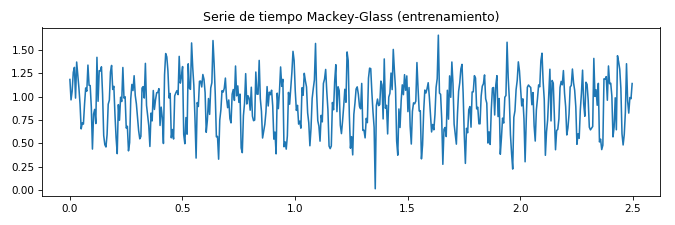

In [165]:
# número de observaciones (no modificar)
N = 1000
# Razón señal a ruido (2., 0.5)
SNR = 2.
# constantes de la ecuación diferencial (no modificar)
a, b = 0.1, 0.2
# comportamiento dinámico de Mackey-Glass (17, 30)
tau = 17.
# paso de integración (no modificar)
dt = 0.05
# condición incial (no modificar)
y0 = 0.9
# largo temporal (no modificar)
tt = 5.
t = np.linspace(0, tt, num=N)

N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))
# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

***

1. Describa en detalle el algoritmo LMS indicando sus semejanzas y diferencias con el filtro de Wiener 
1. Partiendo del error instantaneo $J_n^s(\textbf{w}) = e_n^2$ derive la regla de actualización de pesos
1. La siguiente clase de *Python* predice y entrena un filtro LMS. Complete la línea que dice 

` self.w = ? `

con el valor correcto de actualización de peso del filtro LMS

## Respuestas

### 1. Describa en detalle el algoritmo LMS indicando sus semejanzas y diferencias con el filtro de Wiener

### El filtro de Wiener básico consistiría en obtener los coeficientes de un sistema LTI después de un paso previo deterministico de "entrenamiento" del cual si el sistema LTI obtenido se convoluciona con la señal diseñada debe ser capaz de cumplir su objetivo de filtrado.
### A diferencia del algoritmo de LMS que consiste en la obtención de un sistema adaptativo tal que actualiza recursivamente sus pesos con su matriz de correlación instantanea.
### La principal semejanza es el de la función final de ambos algoritmos de filtro si se les entrena igual, pero la diferencia principal es que Wiener considerando la muestra de entrenamiento dada, ésta sería optima, mientras que LMS no lo sería (aunque tendería a serlo) pero al ser capaz de ser modificada a medida en tiempo real sin necesidad de repetir todo el algoritmo con la nueva información, se obtiene una optimización del lado del rendimiento muy considerable.

### 2. Partiendo del error instantaneo $J_n^s(\textbf{w}) = e_n^2$ derive la regla de actualización de pesos

-Sea $w_n$ el peso de los coeficientes en el filtro y $\mu$ como el paso, como en el caso del algoritmo lms que es una extencion del filtro wiener como un caso no estacionario usando SGD " $J_n^s(\textbf{w}) = e_n^2$" entonces:

$$
w_{t+1} = w_t - \mu \frac{dJ(w)}{dw}
$$

Y como:


\begin{align}
J^s_n(\textbf{w}) &= e_n^2 \nonumber \\
&= (d_n - y_n)^2 \nonumber \\
&= (d_n - \sum_{k=0}^{L} w_{n, k} u_{n-k} )^2 \nonumber \\
\end{align}

Entonces calculamos su derivada:

$$
\frac{dJ(w)}{dw} =   2 (d_n - \sum_{k=0}^{L} w_{n, k} u_{n-k})  u_{n-k}
$$

conciderando que 

$$
e_n = d_n - y_n
$$

Tendremos que:

$$
\frac{dJ(w)}{dw} =   2 e_n u_{n-k}
$$

Y reemplazando en la regla de actualizacion de pesos finalmente obtendremos:

\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu e_n \textbf{u}_{n}\nonumber \\
\end{align}

### 3. La siguiente clase de Python predice y entrena un filtro LMS. Complete la línea que dice
` self.w = ? `
### con el valor correcto de actualización de peso del filtro LMS


$$
\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu (d_n -  \textbf{w}_{n}^T \textbf{u}_{n}) \textbf{u}_{n}, \nonumber 
\end{align}
$$

In [166]:
class LMS_filter(object):
    
    def __init__(self, L=1, mu=0.5, normalized=True):
        self.L = L
        self.mu = mu
        self.w = np.zeros(shape=(L, ))
        self.normalized = normalized
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):
        ## d es la señal deseada
        ## u es la señal obtenida con ruido
        d_pred = self.predict(u)
        norm = 1.
        if self.normalized:
            norm = np.sum(u**2) + 1e-6
        self.w = self.w + 2*self.mu*(d - d_pred)*u/norm

***
## Predicción con algoritmo LMS

1. Entrene el predictor con el algoritmo normalized LMS usando el siguiente bloque de código
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\mu$ y $L$
    - Se recomienda hacer un barrido logarítmico en $\mu$ (por ejemplo `mu=np.logspace(-2, 0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Se sobreajusta el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
***

1. Repita el experimento para $\tau = 30$ (comportamiento fuertemente caótico) 
1. Compare los resultados obtenidos con cada serie de tiempo. ¿Qué caso es más sencillo y cual es más complicado?


## 1. Entrene el predictor con el algoritmo normalized LMS usando el siguiente bloque de código

In [167]:
mu = np.logspace(-2, 0, num=20)
#print(mu)
L = [5, 10, 20, 30]

tabla = np.zeros((len(mu), len(L)*2))
#print(tabla)
experimentos = {
    "optimo": [],
    "media": [],
    "inestable": []
}

optimo_mu = -1
optimo_l = -1
optimo_num = 9999999

cont_mu = 0
for i in mu:
    cont_columna = 0
    
    cont_l = 0
    for j in L:
        lms = LMS_filter(L=j, mu=i, normalized=True)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(lms.__len__(), 500):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
            lms.update(d=y_obs[k], u=y_window)
        # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
        ## Optimo
        if (cont_mu == 9 and cont_l == 3):
            experimentos["optimo"] = y_pred
        elif (cont_mu == 19 and cont_l == 0): ## Inestable
            experimentos["inestable"] = y_pred
        elif (cont_mu == 14 and cont_l == 1): ## Media
            experimentos["media"] = y_pred
            
            
        entrenamiento = NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500])
        prueba = NMSE(ymg[500:], y_pred[500:])
        if (prueba < optimo_num):
            optimo_mu = cont_mu
            optimo_l = cont_l
            optimo_num = prueba
        tabla[cont_mu][cont_columna] = np.format_float_scientific(entrenamiento, 7)
        tabla[cont_mu][cont_columna+1] = np.format_float_scientific(prueba, 7)
        #print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
        #                                                NMSE(ymg[500:], y_pred[500:])))
        cont_l += 1
        cont_columna += 2
    cont_mu += 1

print("El mu optimo es: " + str(mu[optimo_mu]) + ", junto con el L optimo: " + str(L[optimo_l]) + ", con MSE de prueba: " + str(optimo_num))
print("El mu peor es: " + str(mu[19]) + ", junto con el L peor: " + str(L[0]) + ", con MSE de prueba: " + str(tabla[19][1]))
print("El mu media es: " + str(mu[14]) + ", junto con el L media: " + str(L[1]) + ", con MSE de prueba: " + str(tabla[14][3]))

El mu optimo es: 0.08858667904100823, junto con el L optimo: 30, con MSE de prueba: 187.9156101628255
El mu peor es: 1.0, junto con el L peor: 5, con MSE de prueba: 94442.719
El mu media es: 0.29763514416313175, junto con el L media: 10, con MSE de prueba: 431.73311


## 2. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de  𝜇  y  𝐿 


In [168]:
pd.DataFrame(tabla, columns=["5_entrenamiento","5_prueba", "10_entrenamiento", "10_prueba", "20_entrenamiento", "20_prueba", "30_entrenamiento", "30_prueba"])

,5_entrenamiento,5_prueba,10_entrenamiento,10_prueba,20_entrenamiento,20_prueba,30_entrenamiento,30_prueba
0,1227.87540,772.85941,912.09905,423.23028,902.90376,384.04883,886.42052,393.91738
1,1136.92040,737.47381,804.23052,397.23155,794.98792,356.40785,780.53695,367.70992
2,1058.87280,699.63728,713.67271,369.69370,704.57338,326.18650,692.56055,338.82778
3,990.57804,660.83720,635.91783,342.03376,626.49684,294.54077,616.85319,308.24675
4,930.76345,622.75824,568.64921,316.11199,557.82102,263.24086,549.89654,277.45550
5,879.28133,587.18040,511.08679,293.96684,497.42285,234.60747,490.10847,248.36634
6,836.28797,555.90646,463.09653,277.33841,445.22306,211.29791,437.24531,223.11385
7,801.89546,530.89060,424.52261,267.08655,401.43655,195.90006,391.66776,203.76819
8,776.41860,514.48872,394.95418,262.80051,366.09977,190.28607,353.75686,191.89525
9,760.87224,509.46698,373.83567,263.09126,338.87636,194.81113,323.58430,187.91561


## 3. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa

## La prueba optima con 𝜇≈0.0886 y L=30

<IPython.core.display.Javascript object>


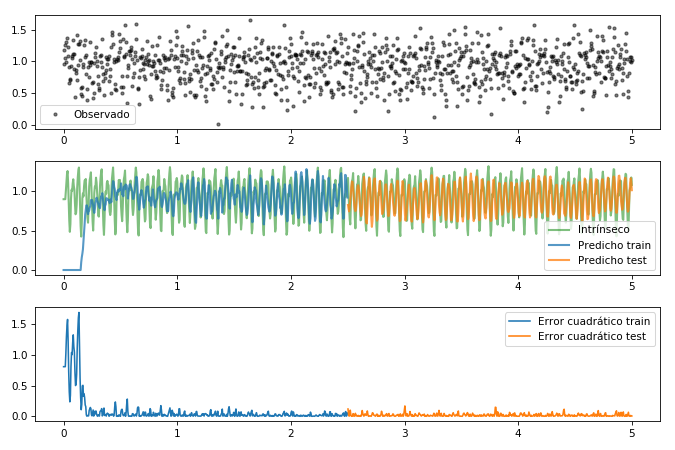

In [169]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos["optimo"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos["optimo"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos["optimo"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos["optimo"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## La prueba media con 𝜇≈0.298 y L=10

<IPython.core.display.Javascript object>


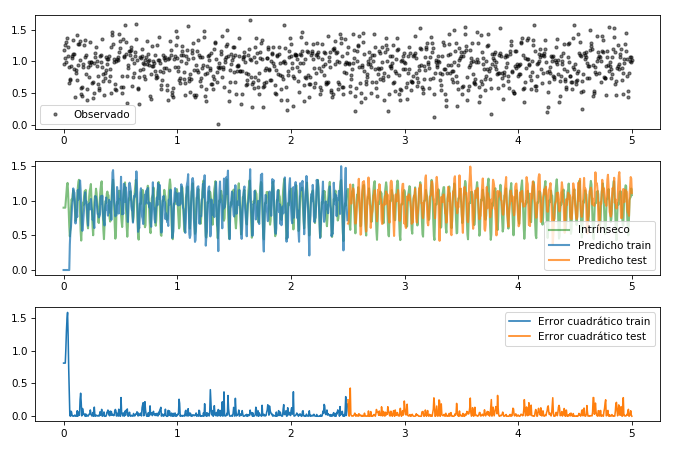

In [170]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos["media"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos["media"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos["media"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos["media"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## La prueba mas inestable con 𝜇=1 y L=5

<IPython.core.display.Javascript object>


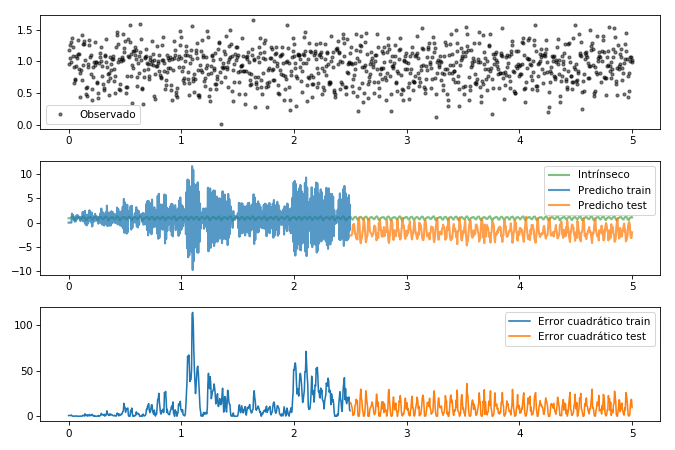

In [171]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos["inestable"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos["inestable"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos["inestable"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos["inestable"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## Conclusiones Cualitativas
Con los datos obtenido podemos ver que en el caso óptimo no existe casi sobreajuste, se demora un poco mas de la media en ajustarse (≈ 0.21 [seg]) pero una vez pasado ese tiempo, el error es mínimo.

Como podemos ver en el caso elegido de forma aleatoriamente como media, es muy rápido en ajustarse (≈ 0.06 [seg]) pero su error a lo largo del tiempo es mayor que el óptimo. La media también se sobreajusta un poco mas que la óptima.

En ningún casi ni en el optimo ni en la media se desestabiliza.

Pero en los datos obtenidas cuantitativamente se pudo distinguir 𝜇=1 el cual es completamente inestable, al no ser capaz de obtener nada de él e incluso empeorando el ruido.


## 4. Indique que combinación obtiene menor MSE de prueba

### La combinación que obtiene el mejor MSE de prueba es:  𝜇≈0.0886 y L=30 con un MSE ≈ 187.9

## 1. Repita el experimento para  𝜏=30  (comportamiento fuertemente caótico)

<IPython.core.display.Javascript object>


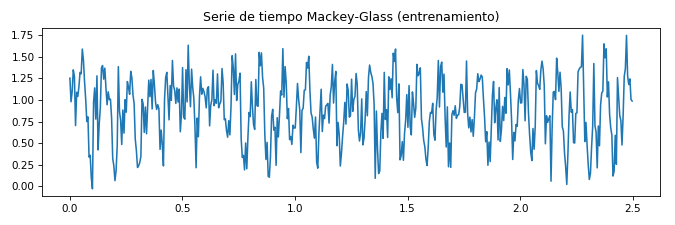

In [172]:
# número de observaciones (no modificar)
N = 1000
# Razón señal a ruido (2., 0.5)
SNR = 2.
# constantes de la ecuación diferencial (no modificar)
a, b = 0.1, 0.2
# comportamiento dinámico de Mackey-Glass (17, 30)
tau = 30.
# paso de integración (no modificar)
dt = 0.05
# condición incial (no modificar)
y0 = 0.9
# largo temporal (no modificar)
tt = 5.
t = np.linspace(0, tt, num=N)

N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))
# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

In [173]:
mu = np.logspace(-2, 0, num=20)
#print(mu)
L = [5, 10, 20, 30]

tabla = np.zeros((len(mu), len(L)*2))
#print(tabla)
experimentos = {
    "optimo": [],
    "media": [],
    "inestable": []
}

optimo_mu = -1
optimo_l = -1
optimo_num = 9999999

cont_mu = 0
for i in mu:
    cont_columna = 0
    
    cont_l = 0
    for j in L:
        lms = LMS_filter(L=j, mu=i, normalized=True)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(lms.__len__(), 500):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
            lms.update(d=y_obs[k], u=y_window)
        # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
        ## Optimo
        if (cont_mu == 8 and cont_l == 2):
            experimentos["optimo"] = y_pred
        elif (cont_mu == 19 and cont_l == 0): ## Inestable
            experimentos["inestable"] = y_pred
        elif (cont_mu == 13 and cont_l == 2): ## Media
            experimentos["media"] = y_pred
            
            
        entrenamiento = NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500])
        prueba = NMSE(ymg[500:], y_pred[500:])
        if (prueba < optimo_num):
            optimo_mu = cont_mu
            optimo_l = cont_l
            optimo_num = prueba
        tabla[cont_mu][cont_columna] = np.format_float_scientific(entrenamiento, 7)
        tabla[cont_mu][cont_columna+1] = np.format_float_scientific(prueba, 7)
        #print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
        #                                                NMSE(ymg[500:], y_pred[500:])))
        cont_l += 1
        cont_columna += 2
    cont_mu += 1

print("El mu optimo es: " + str(mu[optimo_mu]) + ", junto con el L optimo: " + str(L[optimo_l]) + ", con MSE de prueba: " + str(optimo_num))
print("El mu peor es: " + str(mu[19]) + ", junto con el L peor: " + str(L[0]) + ", con MSE de prueba: " + str(tabla[19][1]))
print("El mu media es: " + str(mu[13]) + ", junto con el L media: " + str(L[2]) + ", con MSE de prueba: " + str(tabla[13][5]))

El mu optimo es: 0.06951927961775606, junto con el L optimo: 20, con MSE de prueba: 316.13327870121094
El mu peor es: 1.0, junto con el L peor: 5, con MSE de prueba: 446613.87
El mu media es: 0.23357214690901212, junto con el L media: 20, con MSE de prueba: 596.68017


In [174]:
pd.DataFrame(tabla, columns=["5_entrenamiento","5_prueba", "10_entrenamiento", "10_prueba", "20_entrenamiento", "20_prueba", "30_entrenamiento", "30_prueba"])

,5_entrenamiento,5_prueba,10_entrenamiento,10_prueba,20_entrenamiento,20_prueba,30_entrenamiento,30_prueba
0,757.43894,484.93771,870.85517,575.73650,767.26941,442.65827,756.82073,428.18495
1,703.71135,468.75168,808.26564,548.91806,700.75418,422.04793,692.23804,409.30977
2,657.68697,451.33370,753.36615,520.86226,644.34443,400.35381,637.89352,389.44987
3,617.53584,433.04409,703.98465,492.92924,594.56247,378.76632,590.01740,369.85237
4,582.71906,414.37207,659.27834,466.71731,549.46017,358.65720,546.23309,351.97134
5,553.51610,396.20673,619.39730,444.11555,508.42383,341.34644,505.50006,337.18348
6,530.49512,379.89639,584.97900,427.11933,471.67856,327.88382,467.72619,326.48667
7,514.21867,367.07000,556.71143,417.44291,439.79304,319.11206,433.26897,320.52059
8,505.22293,359.42684,535.08086,416.09057,413.41394,316.13328,402.56513,320.03928
9,504.12234,359.18237,520.27671,423.32960,393.22169,321.08832,375.97558,326.62964


## La prueba optima con 𝜇≈0.07 y L=20

<IPython.core.display.Javascript object>


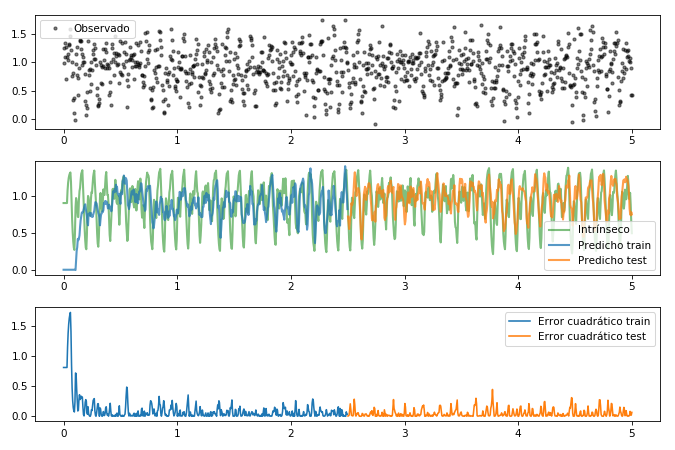

In [175]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos["optimo"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos["optimo"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos["optimo"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos["optimo"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## La prueba media con 𝜇≈0.23 y L=20

<IPython.core.display.Javascript object>


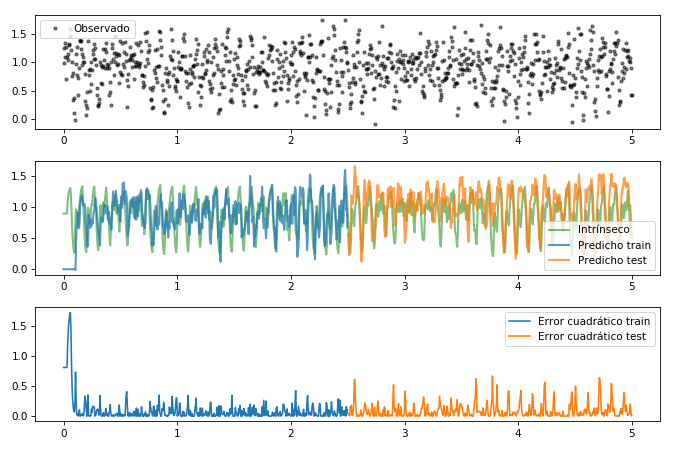

In [176]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos["media"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos["media"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos["media"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos["media"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## La prueba mas inestable con 𝜇=1 y L=5

<IPython.core.display.Javascript object>


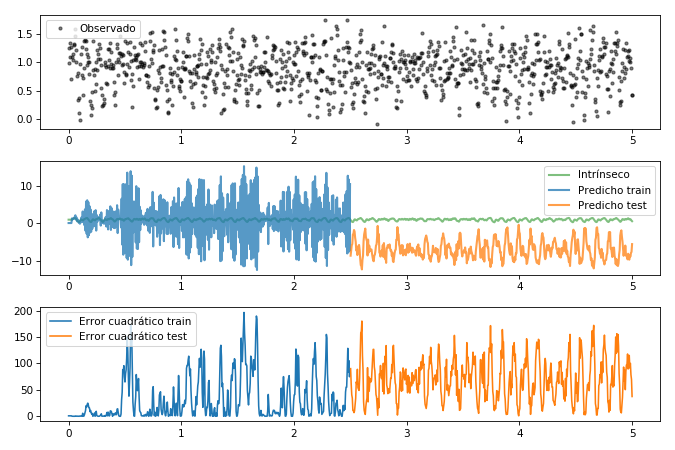

In [177]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos["inestable"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos["inestable"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos["inestable"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos["inestable"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## 2. Compare los resultados obtenidos con cada serie de tiempo. ¿Qué caso es más sencillo y cual es más complicado?

Para la serie de tiempo 𝜏=17 en comparación con 𝜏=30 en los casos óptimos podemos concluir que para la primera se demora más en estabilizarse pero a lo largo del tiempo tiene considerablemente menos error, en contraste con la segunda, que aunque se demora menos en estabilizarse, tiene mas error y tiende a ser mas dificil de predecir.

Para los casos inestables se puede observar que para 𝜏=30 tiende a ser aún peor que 𝜏=17 en todos los casos.


A lo largo del tiempo 𝜏=17 es mucho mas sencillo de predecir ya que los valores no fluctúan tanto como en el segundo caso.

<IPython.core.display.Javascript object>


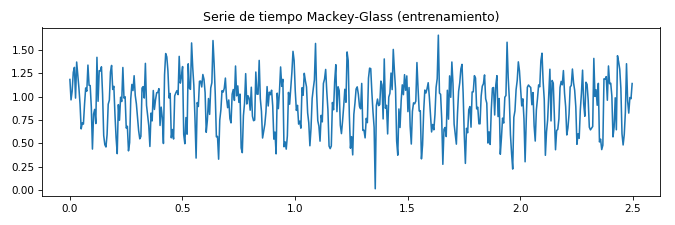

In [178]:
# número de observaciones (no modificar)
N = 1000
# Razón señal a ruido (2., 0.5)
SNR = 2.
# constantes de la ecuación diferencial (no modificar)
a, b = 0.1, 0.2
# comportamiento dinámico de Mackey-Glass (17, 30)
tau = 17.
# paso de integración (no modificar)
dt = 0.05
# condición incial (no modificar)
y0 = 0.9
# largo temporal (no modificar)
tt = 5.
t = np.linspace(0, tt, num=N)

N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))
# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

***
## Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS indicando sus semejanzas y diferencias con el algoritmo LMS
1. Partiendo del error histórico $J_N(\textbf{w}) = \sum_{i=1}^N \beta^{N-i} e_i^2$ derive la regla recursiva de actualización de pesos 
1. La siguiente clase de *Python* predice y entrena un filtro RLS. Complete las líneas que dice 

` self.w = ? ` y `self.Phi_inv = ?`

con el valor correcto de actualización de peso del filtro RLS

## Respuestas

### 1. Describa en detalle el algoritmo RLS indicando sus semejanzas y diferencias con el algoritmo LMS

### El algoritmo RLS se base en el algoritmo mencionado anteriormente LMS, pero ocupando caracteristicas online o acumulativas / recursivas, que permiten que el algoritmo se adapte mas rápido, lo que implica una convergencia más rápida del algoritmo.

### Ventajas RLS sobre LMS: La ventaja es que converge mas rápido

### Desventajas RLS sobre LMS: Mayor complejidad computacional (O(L²) > O(L))


### 2. Partiendo del error histórico $J_N(\textbf{w}) = \sum_{i=1}^N \beta^{N-i} e_i^2$ derive la regla recursiva de actualización de pesos


Sea: 
$$
\begin{align}
J^H_n(\textbf{w}) &= \sum_{i=L}^n   \beta^{n-i} |e_i|^2 \nonumber \\
\end{align}
$$

Derivamos y se iguala a cero para obtener el obtimo

$$
\begin{align}
\frac{d J^H_n (\textbf{w})}{d w_{n, k}} &= 2 \sum_{i=1}^n   \beta^{n-i} e_i \frac{de_i}{d w_{n, k}} = 0
\nonumber \\
\end{align}
$$

Como:
$$
\begin{align}
e_n = d_n - \sum_{k=0}^{L} w_{n, k} u_{n-k} \nonumber 
\end{align}
$$
Y:
$$
\begin{align}
\frac{de_i}{d w_{n, k}} &= u_{n-k}
\end{align}
$$
Entonces obtenemos:

$$
\begin{align}
\frac{d J^H_n (\textbf{w})}{d w_{n, k}} &= 2 \sum_{i=1}^n   \beta^{n-i} [d_i - \sum_{k=0}^{L} w_{n, k} u_{n-k}]u_{n-k} = 0
\nonumber \\
\end{align}
$$
Nos queda la siguiente ecuación:
$$
\begin{align}
\sum_{i=1}^n   \beta^{n-i} [d_i - \sum_{l=0}^{L} w_{n, k} u_{i-l}]u_{i-k} = 0
\nonumber \\
\end{align}
$$

Y ordenamos la ecuacion de tal forma que:
$$
\begin{align}
\sum_{l=1}^L  w_{n, k} [ \sum_{i=0}^{n}  \beta^{n-i} u_{i-l}u_{i-k}] = \sum_{i=0}^{n}  \beta^{n-i} d_i u_{i-k}
\nonumber \\
\end{align}
$$

Definimos las siguientes matrices:

$$
\textbf{d}_n = \begin{pmatrix}  d_n \\ d_{n-1} \\ \vdots \\ d_{L+1} \end{pmatrix} \quad
\textbf{u}_n = \begin{pmatrix}  u_n \\ u_{n-1} \\ \vdots \\ u_{n-(L+1)} \end{pmatrix} \quad
\pmb{\beta} = I \begin{pmatrix} \beta \\ \beta^{1} \\ \beta^{2}  \vdots \\ \beta^{n-L-1} \end{pmatrix}
\quad 
U_n = \begin{pmatrix}
\textbf{u}_n^T \\ \textbf{u}_{n-1}^T \\ \vdots \\ \textbf{u}_{L+1}^T \\
\end{pmatrix} \in \mathbb{R}^{n - (L+1) \times L+1}
$$

Por lo que en la forma matricial de la ultima ecuación(solución cerrada):

$$
\textbf{w}_n (U_n^T \pmb{\beta} U_n + \delta I) = U_n^T \pmb{\beta} \textbf{d}_n $$


$$
\textbf{w}_n = (U_n^T \pmb{\beta} U_n + \delta I)^{-1} U_n^T \pmb{\beta} \textbf{d}_n$$

Expresa en forma matricial empaquetando la correlacion ponderada y regularizada y la correlacion ponderada 

  - Matriz de correlación ponderada y regularizada: $\Phi_n = U_n^T \pmb{\beta} U_n + \delta I$
  - Vector de correalación cruzada ponderada:  $\theta_n = U_n^T \pmb{\beta} \textbf{d}_n$
  
Quedando:
$$
\begin{align}
\textbf{w}_n = \Phi_n^{-1} \theta_n
\end{align}
$$

### 3. La siguiente clase de *Python* predice y entrena un filtro RLS. Complete las líneas que dice 

` self.w = ? ` y `self.Phi_inv = ?`

con el valor correcto de actualización de peso del filtro RLS


$$
\begin{align}
\textbf{w}_n = \textbf{w}_{n-1} + \textbf{k}_n e_n 
\end{align}
$$

$$
\begin{align}
\Phi_{n}^{-1} = \beta^{-1} \Phi_{n-1}^{-1} - \beta^{-1} \textbf{k}_n \textbf{u}_n^T \Phi_{n-1}^{-1}
\end{align}
$$

In [179]:
class RLS_filter(object):
    
    def __init__(self, L=1, beta=0.9, delta=10.):
        self.L = L
        self.beta = beta
        self.w = np.zeros(shape=(L, ))
        self.Phi_inv = delta*np.eye(L)
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):          
        invbeta = 1.0/self.beta
        d_pred = self.predict(u)
        e = d - d_pred
        r = 1. + invbeta*np.dot(np.dot(u, self.Phi_inv), u.T)
        k = invbeta*np.dot(self.Phi_inv, u)/r       
        self.Phi_inv = invbeta*self.Phi_inv - invbeta*k*d_pred*self.Phi_inv
        self.w = self.w + k*e
        

***

1. Entrene el predictor con el algoritmo RLS usando el siguiente bloque de código
1. Considere primero  $\tau=17$
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\beta$ y $L$
    - Se recomienda hacer un barrido lineal en $\beta$ (por ejemplo `mu=np.linspace(0.8, 1.0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Cuánto demora el filtro en estabilizarse? 
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
1. Repita el experimento para $\tau=30$
1. Compare con los resultados obtenidos con el algoritmo LMS ¿Qué algoritmo demora menos en converger?


### 1. y 2.   
#### Entrene el predictor con el algoritmo RLS usando el siguiente bloque de código, Considere primero  $\tau=17$

In [180]:
rls = RLS_filter(L=30, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 226.1382, prueba 345.8687


### 3. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\beta$ y $L$

In [181]:
beta = np.linspace(0.8, 1.0, num=20)
#print(beta)
L = [5, 10, 20, 30]

tabla_2 = np.zeros((len(beta), len(L)*2))
#print(tabla)
experimentos_2 = {
    "optimo": [],
    "media": [],
    "inestable": []
}

optimo_beta = -1
optimo_l = -1
optimo_num = 9999999

peor_beta = -1
peor_l = -1
peor_num = -1

cont_beta = 0
for i in beta:
    cont_columna = 0
    
    cont_l = 0
    for j in L:
        rls = RLS_filter(L=j, beta=i)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(rls.__len__(), 500):
            y_window = y_obs[k-rls.__len__():k]
            y_pred[k] = rls.predict(y_window)
            rls.update(d=y_obs[k], u=y_window)
        # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-rls.__len__():k]
            y_pred[k] = rls.predict(y_window)
        ## Optimo
        if (cont_beta == 19 and cont_l == 2):
            experimentos_2["optimo"] = y_pred
        elif (cont_beta == 0 and cont_l == 0): ## Inestable
            experimentos_2["inestable"] = y_pred
        elif (cont_beta == 7 and cont_l == 2): ## Media
            experimentos_2["media"] = y_pred
            
            
        entrenamiento = NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500])
        prueba = NMSE(ymg[500:], y_pred[500:])
        if (prueba < optimo_num):
            optimo_beta = cont_beta
            optimo_l = cont_l
            optimo_num = prueba
        if (prueba > peor_num):
            peor_beta = cont_beta
            peor_l = cont_l
            peor_num = prueba
        tabla_2[cont_beta][cont_columna] = np.format_float_scientific(entrenamiento, 7)
        tabla_2[cont_beta][cont_columna+1] = np.format_float_scientific(prueba, 7)
        #print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
        #                                                NMSE(ymg[500:], y_pred[500:])))
        cont_l += 1
        cont_columna += 2
    cont_beta += 1

print("El beta optimo es: " + str(beta[optimo_beta]) + ", junto con el L optimo: " + str(L[optimo_l]) + ", con MSE de prueba: " + str(optimo_num))
print("El beta peor es: " + str(beta[peor_beta]) + ", junto con el L peor: " + str(L[peor_l]) + ", con MSE de prueba: " + str(peor_num))
print("El beta media es: " + str(beta[7]) + ", junto con el L media: " + str(L[2]) + ", con MSE de prueba: " + str(tabla_2[7][5]))

El beta optimo es: 1.0, junto con el L optimo: 20, con MSE de prueba: 214.03582058041417
El beta peor es: 0.8, junto con el L peor: 5, con MSE de prueba: 1223.3335127245598
El beta media es: 0.8736842105263158, junto con el L media: 20, con MSE de prueba: 476.28962


In [182]:
pd.DataFrame(tabla_2, columns=["5_entrenamiento","5_prueba", "10_entrenamiento", "10_prueba", "20_entrenamiento", "20_prueba", "30_entrenamiento", "30_prueba"])

,5_entrenamiento,5_prueba,10_entrenamiento,10_prueba,20_entrenamiento,20_prueba,30_entrenamiento,30_prueba
0,994.20709,1223.33350,487.85819,1101.03940,351.03974,476.32724,322.83193,346.01555
1,978.86941,1130.25680,487.85000,1101.03630,351.03913,476.32381,322.83145,346.01486
2,958.08595,1033.87770,487.83998,1101.03240,351.03845,476.31996,322.83090,346.01403
3,936.52890,946.28512,487.82747,1101.02750,351.03767,476.31561,322.83025,346.01304
4,914.65772,867.91568,487.81131,1101.02080,351.03674,476.31063,322.82946,346.01186
5,892.69012,799.57147,487.78941,1101.01130,351.03558,476.30485,322.82852,346.01041
6,870.73595,741.50416,487.75748,1100.99680,351.03407,476.29799,322.82735,346.00863
7,848.82680,693.29775,487.70568,1100.97270,351.03203,476.28962,322.82589,346.00638
8,826.96665,653.87550,487.60715,1100.92640,351.02912,476.27902,322.82402,346.00349
9,805.16296,621.60080,487.36061,1100.75390,351.02477,476.26482,322.82154,345.99964


## 4. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa

## La prueba optima con β=1.0 y L=20

<IPython.core.display.Javascript object>


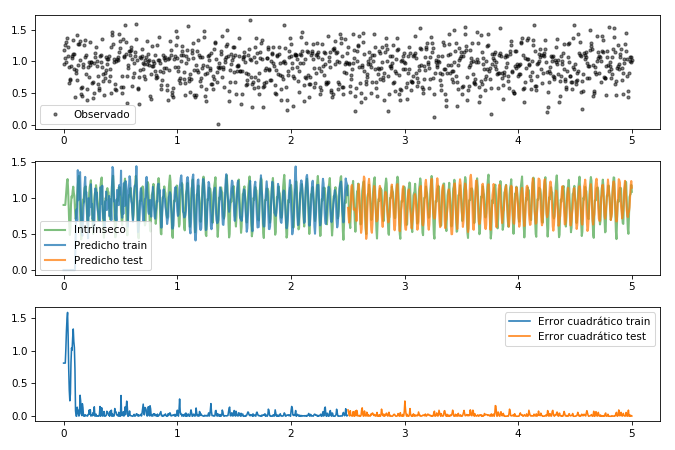

In [183]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos_2["optimo"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos_2["optimo"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos_2["optimo"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos_2["optimo"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## La prueba media con β≈0.874 y L=20

<IPython.core.display.Javascript object>


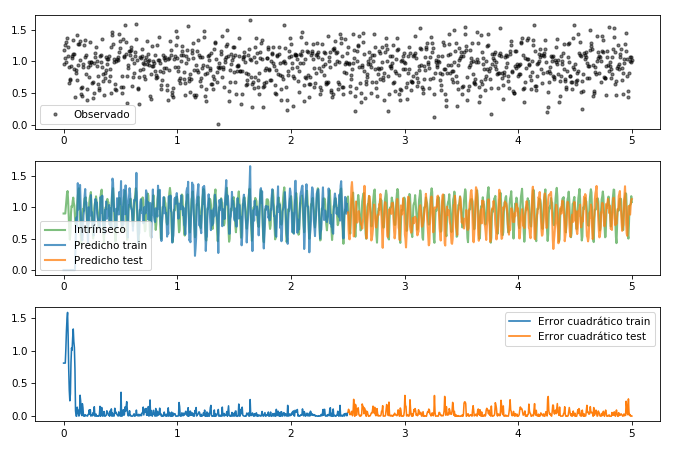

In [184]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos_2["media"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos_2["media"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos_2["media"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos_2["media"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## La prueba mas inestable con β=0.8 y L=5

<IPython.core.display.Javascript object>


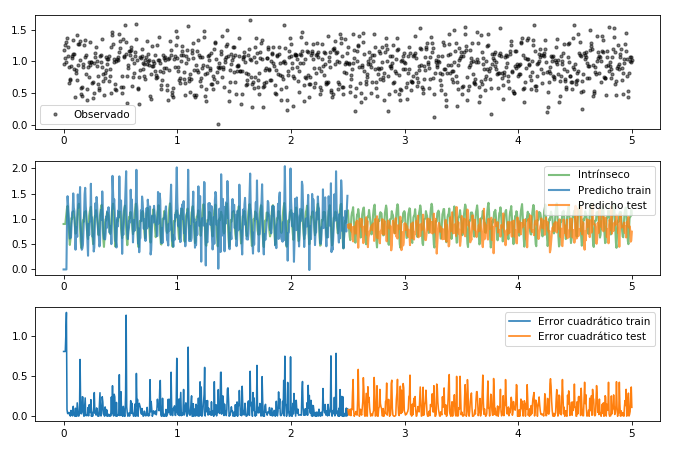

In [185]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos_2["inestable"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos_2["inestable"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos_2["inestable"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos_2["inestable"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## Conclusiones Cualitativas

Con los datos obtenido podemos ver que en el caso óptimo no existe casi sobreajuste y se demora casi lo mismo que la media en ajustarse (≈ 0.10 [seg]) y su error en general es muy bajo luego del ajuste.

Como podemos ver en el caso elegido de forma aleatoriamente como media, es muy rápido en ajustarse al igual que en el caso óptimo (≈ 0.10 [seg]) pero su error a lo largo del tiempo es considerablemente mayor que el óptimo. Y también se sobreajusta un poco mas que la óptima pero de forma muy moderada.

En los datos obtenidos no hubo ninguno que se haya disparado como lo fue en el caso anterior, simplemente llegamos a un peor objetivamente hablando en el que se puede observar que se demora muy poco en "estabilizarse" (siesque se le puede clasificar así) (≈ 0.04 [seg]), pero el error obtenido en promedio es mucho mayor que en los 2 casos anteriores, y existe un sobreajuste muy considerable del filtro con respecto a los datos de entrenamiento.


## 5. Indique que combinación obtiene menor MSE de prueba 

#### La combinación que obtiene el mejor MSE de prueba es:  β=1.0 y L=20 con un MSE ≈ 214.04

## 6. Repita el experimento para $\tau=30$

<IPython.core.display.Javascript object>


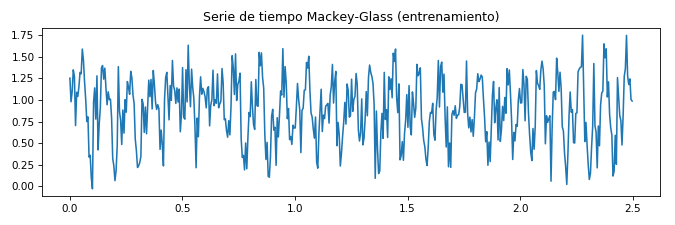

In [186]:
# número de observaciones (no modificar)
N = 1000
# Razón señal a ruido (2., 0.5)
SNR = 2.
# constantes de la ecuación diferencial (no modificar)
a, b = 0.1, 0.2
# comportamiento dinámico de Mackey-Glass (17, 30)
tau = 30.
# paso de integración (no modificar)
dt = 0.05
# condición incial (no modificar)
y0 = 0.9
# largo temporal (no modificar)
tt = 5.
t = np.linspace(0, tt, num=N)

N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))
# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

In [187]:
rls = RLS_filter(L=30, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 220.7530, prueba 1415.9566


In [188]:
beta = np.linspace(0.8, 1.0, num=20)
#print(beta)
L = [5, 10, 20, 30]

tabla_2 = np.zeros((len(beta), len(L)*2))
#print(tabla)
experimentos_2 = {
    "optimo": [],
    "media": [],
    "inestable": []
}

optimo_beta = -1
optimo_l = -1
optimo_num = 9999999

peor_beta = -1
peor_l = -1
peor_num = -1

cont_beta = 0
for i in beta:
    cont_columna = 0
    
    cont_l = 0
    for j in L:
        rls = RLS_filter(L=j, beta=i)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(rls.__len__(), 500):
            y_window = y_obs[k-rls.__len__():k]
            y_pred[k] = rls.predict(y_window)
            rls.update(d=y_obs[k], u=y_window)
        # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-rls.__len__():k]
            y_pred[k] = rls.predict(y_window)
        ## Optimo
        if (cont_beta == 17 and cont_l == 0):
            experimentos_2["optimo"] = y_pred
        elif (cont_beta == 5 and cont_l == 0): ## Inestable
            experimentos_2["inestable"] = y_pred
        elif (cont_beta == 14 and cont_l == 1): ## Media
            experimentos_2["media"] = y_pred
            
            
        entrenamiento = NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500])
        prueba = NMSE(ymg[500:], y_pred[500:])
        if (prueba < optimo_num):
            optimo_beta = cont_beta
            optimo_l = cont_l
            optimo_num = prueba
        if (prueba > peor_num):
            peor_beta = cont_beta
            peor_l = cont_l
            peor_num = prueba
        tabla_2[cont_beta][cont_columna] = np.format_float_scientific(entrenamiento, 7)
        tabla_2[cont_beta][cont_columna+1] = np.format_float_scientific(prueba, 7)
        #print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
        #                                                NMSE(ymg[500:], y_pred[500:])))
        cont_l += 1
        cont_columna += 2
    cont_beta += 1

print("El beta optimo es: " + str(beta[optimo_beta]) + ", junto con el L optimo: " + str(L[optimo_l]) + ", con MSE de prueba: " + str(optimo_num))
print("El beta peor es: " + str(beta[peor_beta]) + ", junto con el L peor: " + str(L[peor_l]) + ", con MSE de prueba: " + str(peor_num))
print("El beta media es: " + str(beta[14]) + ", junto con el L media: " + str(L[1]) + ", con MSE de prueba: " + str(tabla_2[14][3]))

c:\python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in multiply
c:\python37\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


El beta optimo es: 0.9789473684210527, junto con el L optimo: 5, con MSE de prueba: 323.9191256325547
El beta peor es: 0.8526315789473684, junto con el L peor: 5, con MSE de prueba: 144021.0083309378
El beta media es: 0.9473684210526316, junto con el L media: 10, con MSE de prueba: 822.00062


In [189]:
pd.DataFrame(tabla_2, columns=["5_entrenamiento","5_prueba", "10_entrenamiento", "10_prueba", "20_entrenamiento", "20_prueba", "30_entrenamiento", "30_prueba"])

,5_entrenamiento,5_prueba,10_entrenamiento,10_prueba,20_entrenamiento,20_prueba,30_entrenamiento,30_prueba
0,885.53140,1254.62680,611.96257,2202.86730,473.16670,2344.95870,350.57397,1414.39460
1,902.71404,1324.24440,611.94850,2202.85450,473.16410,2344.95620,350.57358,1414.40030
2,NaN,NaN,611.93091,2202.83850,473.16125,2344.95360,350.57313,1414.40650
3,NaN,NaN,611.90870,2202.81770,473.15808,2344.95120,350.57259,1414.41360
4,351595.33000,69548.73100,611.88026,2202.79040,473.15451,2344.94900,350.57194,1414.42140
5,206265.88000,144021.01000,611.84312,2202.75320,473.15045,2344.94720,350.57115,1414.43020
6,357140.18000,75763.45500,611.79302,2202.69970,473.14574,2344.94620,350.57018,1414.44020
7,599.48411,815.84516,611.72157,2202.61540,473.14016,2344.94610,350.56897,1414.45130
8,577.71966,731.47301,611.60714,2202.44840,473.13335,2344.94720,350.56744,1414.46390
9,557.74333,653.37976,611.35356,2201.80540,473.12469,2344.94940,350.56543,1414.47810


## La prueba optima con β≈0.98 y L=5

<IPython.core.display.Javascript object>


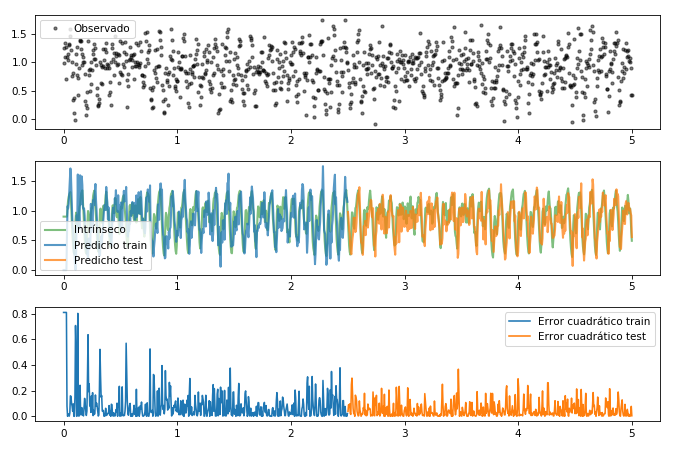

In [190]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos_2["optimo"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos_2["optimo"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos_2["optimo"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos_2["optimo"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## La prueba media con β≈0.95 y L=10

<IPython.core.display.Javascript object>


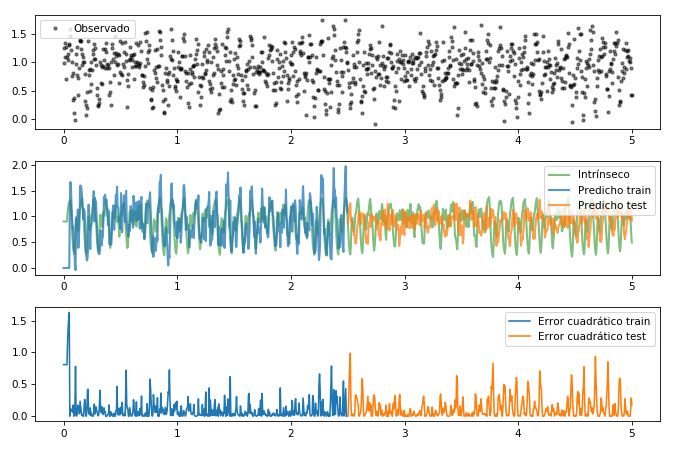

In [191]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos_2["media"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos_2["media"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos_2["media"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos_2["media"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## La prueba mas inestable con β=0.85 y L=5

<IPython.core.display.Javascript object>


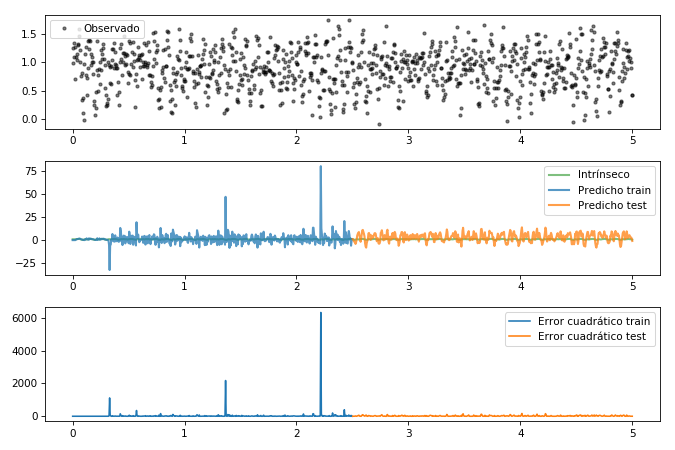

In [192]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos_2["inestable"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos_2["inestable"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos_2["inestable"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos_2["inestable"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## Conclusiones Cualitativas

Comparando con LMS en 𝜏=30, podemos ver que RLS rinde peor, ya que en el caso óptimo se demora alrededor de 0.15 [seg] en hacer una estabilización parcial, pero se llega a demorar hasta 1.0 [seg] para estabilizarse completamente, y su rango de error tiende a ser mas grande.

# 7. Compare con los resultados obtenidos con el algoritmo LMS ¿Qué algoritmo demora menos en converger?

## Finalmente, comparando los resultados ideales de ambos algoritmos en la serie de tiempo mas sencilla (𝜏=17) podemos observar que LMS se demora aproximadamente t≈0.20 [seg] en estabilizarse, mientras que RLS se demora aproximadamente la mitad, t≈0.10 [seg].

## Por lo tanto podemos concluir que en algunas circunstancias el gasto computacional extra que requiere RLS puede valer la pena considerando las ventajas que ésto trae. Pero siempre considerando que RLS puede llegar a ser un poco mas inestable a lo largo del tiempo.